<a href="https://colab.research.google.com/github/DevAggarwal01/Machine-Learning/blob/main/Neural%20Networks/DeepLearningCodingChallenge_VehicleClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip vehicle_classification.zip

In [ ]:
# !pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

import os
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.13.1+cu116


In [ ]:
train_folder = '/content/vehicle_classification'
img_size = (64, 64) # image size is 64 by 64

classes = sorted(os.listdir(train_folder))
print(classes)

['Bicycle', 'Bus', 'Car', 'Motorcycle', 'NonVehicles', 'Taxi', 'Truck', 'Van']


In [ ]:
def load_dataset(data_path):
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data TO REDUCE OVERFITTING
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (80% and testing (20%) datasets)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


In [ ]:
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read /content/vehicle_classification


In [ ]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=8):
        super(Net, self).__init__()
        
        # define each layer we will use in our model
        
        # images are RGB, so input channels = 3. 
        # apply 12 filters in the 1st convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # 2nd convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # 64x64 image tensors pooled twice with a kernel size of 2. 64/2/2 is 16.
        # This means that our feature tensors are now 16 x 16, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=16 * 16 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # drop some features to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 16 * 16 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=6144, out_features=8, bias=True)
)


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
  # training mode
  model.train()
  train_loss = 0
  print('Epoch', epoch)
  # Process images in batches
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    # Reset optimizer
    optimizer.zero_grad()

    # Push data forward through model layers
    output = model(data)

    # Get loss
    loss = loss_criteria(output, target)

    # Keep a running total
    train_loss += loss.item()

    # Backpropoagate
    loss.backward()
    optimizer.step()

    # Print metrics to see progress
    print('\tTraining batch {} loss: {:.6f}'.format(batch_idx+1, loss.item()))

  # return average loss for the epoch
  avg_loss = train_loss/(batch_idx+1)
  print('Training set: Average loss: {:.6f}'.format(avg_loss))
  return avg_loss


In [ ]:
def test(model, device, test_loader):
  # evaluation mode (to avoid backpropagation or drop)
  model.eval()

  test_loss = 0
  correct = 0
  with torch.no_grad():
    batch_count = 0
    for data, target in test_loader:
      batch_count += 1
      data, target = data.to(device), target.to(device)
      
      # Get predictions 
      output = model(data)

      # Calculate loss
      test_loss += loss_criteria(output, target).item()

      # Calculate the accuracy for this batch
      _, predicted = torch.max(output.data, 1)
      correct += torch.sum(target==predicted).item()

  avg_loss = test_loss / batch_count
  print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
  return avg_loss

In [ ]:
# Adam optimizer used to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# loss criteria
loss_criteria = nn.CrossEntropyLoss()

epoch_nums = []
training_loss = []
validation_loss = []

epochs = 10
print('Training on', device)
for epoch in range(1, epochs+1):
  train_loss = train(model, device, train_loader, optimizer, epoch)
  test_loss = test(model, device, test_loader)
  epoch_nums.append(epoch)
  training_loss.append(train_loss)
  validation_loss.append(test_loss)


Training on cpu
Epoch 1
	Training batch 1 loss: 0.893332
	Training batch 2 loss: 4.821102
	Training batch 3 loss: 1.590001
	Training batch 4 loss: 2.726447
	Training batch 5 loss: 2.194105
	Training batch 6 loss: 2.013006
	Training batch 7 loss: 1.668697
	Training batch 8 loss: 1.596057
	Training batch 9 loss: 1.738689
	Training batch 10 loss: 1.566988
	Training batch 11 loss: 1.479391
	Training batch 12 loss: 1.876391
	Training batch 13 loss: 1.802105
	Training batch 14 loss: 1.554852
	Training batch 15 loss: 1.873144
	Training batch 16 loss: 1.491308
	Training batch 17 loss: 1.276625
	Training batch 18 loss: 1.792692
	Training batch 19 loss: 1.502860
	Training batch 20 loss: 1.541547
	Training batch 21 loss: 1.548941
	Training batch 22 loss: 1.371725
	Training batch 23 loss: 1.176152
	Training batch 24 loss: 1.202083
	Training batch 25 loss: 1.626641
	Training batch 26 loss: 1.493586
	Training batch 27 loss: 1.163534
	Training batch 28 loss: 1.556481
	Training batch 29 loss: 1.542900

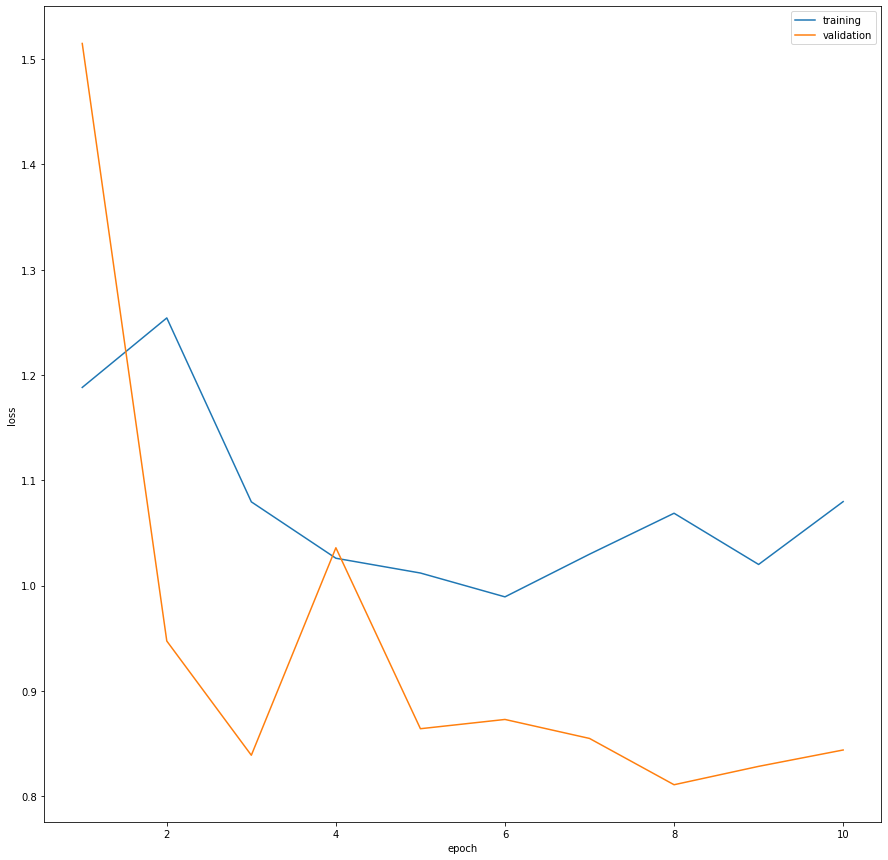

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

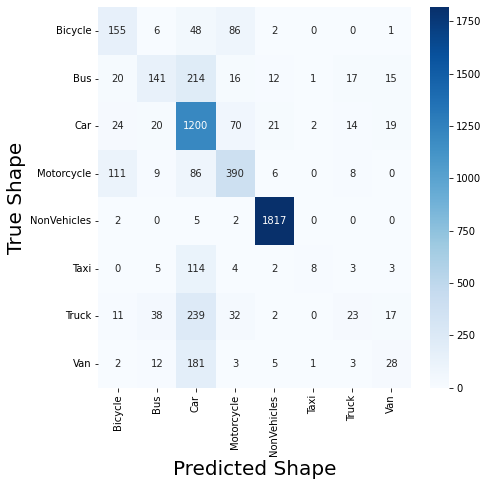

In [ ]:
truelabels = []
predictions = []
model.eval()
for data, target in test_loader:
  for label in target.data.numpy():
    truelabels.append(label)
  for prediction in model(data).data.numpy().argmax(1):
    predictions.append(prediction)

cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

In [ ]:
accuracy_score(y_pred=predictions, y_true=truelabels)

0.7130401819560273